# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [1]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [2]:
pwd()

'/Users/Christopher/Desktop/USC FALL 2022/CMB Lab/Work/qbio577_fall2022'

In [3]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/f6/9t91nmcn29q01prqs5k4c34m0000gq/T/ipykernel_14923/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


# Q1
- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


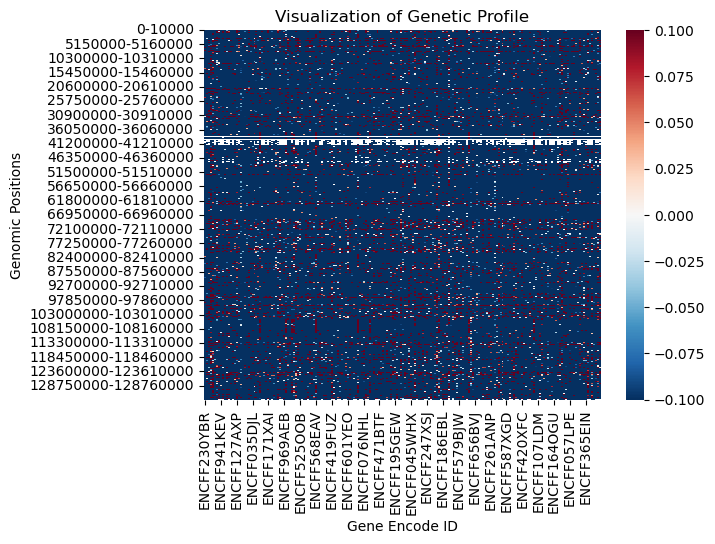

In [4]:
import seaborn as sns
df_temp=df.copy()
df_temp.index = df.iloc[:,1].astype(str) + '-' + df.iloc[:,2].astype(str)
sns.heatmap(np.log2(df_temp[df_temp.columns[3:]]), cmap='RdBu_r')
plt.xlabel('Gene Encode ID')
plt.ylabel('Genomic Positions')
plt.title('Visualization of Genetic Profile')
plt.show()

Signals dip at chr 10 in the 40MB region as a result of being around a centromere wherein the reads are harder to sequence as they are repeats. 

# Q2
- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


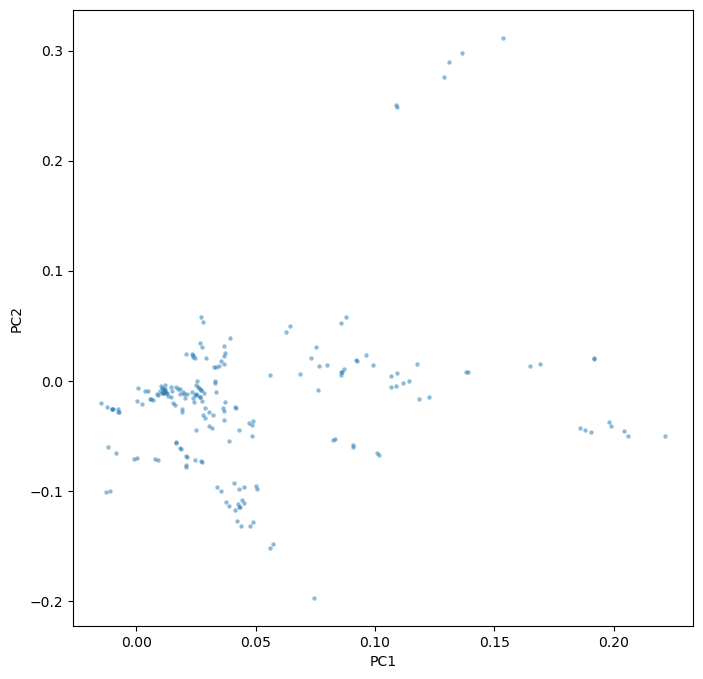

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(df.iloc[:,3:])

plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = None, alpha = 0.5, lw = 0, figsize=(8,8)) 
plt.xlabel('PC1')
plt.ylabel("PC2")
plt.show()

# Q3
- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

NameError: name 'classes' is not defined

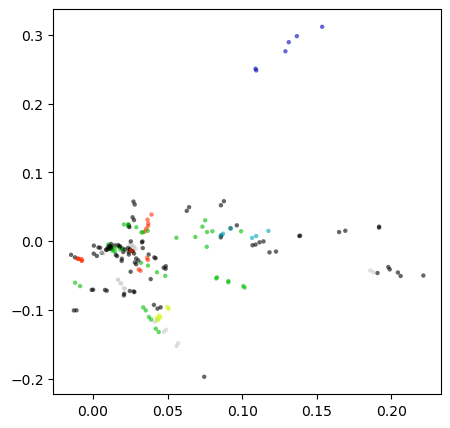

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df.iloc[:, 3:])
#for column in bigwig_metadata.columns:
#    plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = column, alpha = 0.6, lw = 0, figsize=(5,5))
#    plt.title('Plot Based on: '+column)
#    plt.show()

plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Audit ERROR", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on Audit ERROR')
plt.show()

In [ ]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Biosample term name", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on Biosample term name')
plt.show()

In [ ]:
mask = bigwig_metadata[bigwig_metadata['Audit ERROR'] != 'control extremely low read depth, extremely low read depth, missing control alignments']
Filter = mask[mask['File accession'].isin(df.columns[3:])]
df = df.loc[:, df.columns.isin(Filter['File accession'])]

df

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df.iloc[:, 3:])
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Audit ERROR", alpha = 0.6, lw = 0, figsize=(5,5))
plt.title('Plot Based on Audit ERROR')
plt.show()

Removing the samples where the Audit Error flag reads 'control extremely low read depth, extremely low read depth, missing control alignments' will remove only the outliers, and cleans the data so the samples are all at a consistent read depth for the PCA analysis

# Q4
- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(3):
    assay_type =  Filter[Filter['Assay']== (Filter['Assay'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plt.plot(df_assay)
    plt.title(Filter['Assay'].unique()[i])
    plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(3):
    assay_type =  Filter[Filter['Assay']== (Filter['Assay'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plot_acf(df_assay)
    plt.title(Filter['Assay'].unique()[i])

In [ ]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Assay", alpha = 0.6, lw = 0, figsize=(10,10))
plt.title('PCA Plot Based on Assay')
plt.show()

Based on the PCA, the Chip-Seq assays tend to have broad patterns, whereas the ATAC-seq tends to have a more narrow pattern

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(44):
    assay_type =  Filter[Filter['Experiment target']== (Filter['Experiment target'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plt.plot(df_assay)
    plt.title(Filter['Experiment target'].unique()[i])
    plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(44):
    assay_type =  Filter[Filter['Experiment target']== (Filter['Experiment target'].unique()[i])].iloc[0, 1]
    df_assay = df.loc[:,df.columns == assay_type]
    plot_acf(df_assay)
    plt.title(Filter['Experiment target'].unique()[i])
    plt.show()

In [ ]:
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Experiment target", alpha = 0.6, lw = 0, figsize=(10,10), s=15)
plt.title('PCA Plot Based on Experiment Targets')
plt.show()

# Q5
- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


In [ ]:
bigwig_metadata['Type:Target']=bigwig_metadata['Biosample term name'] +"/"+ bigwig_metadata['Experiment target']
plot_pca(pca, bigwig_metadata = bigwig_metadata, metadata_label_column = "Type:Target", alpha = 0.6, lw = 0, figsize=(10,10), s=15)
plt.title('PCA Plot Based on Experiment Targets and Cell Type')
plt.show()

# Q6
- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


In [ ]:
from sklearn.preprocessing import StandardScaler
dfx = df.drop(range(3750,4000), axis=0)

df_mod = StandardScaler().fit_transform(df.iloc[:, 3:-1])
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df_mod)
plot_pca(pca)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Without Preprocessing")
plt.show()

df_mod = StandardScaler().fit_transform(dfx.iloc[:, 3:-1])
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(df_mod)
plot_pca(pca)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('With Preprocessing')
plt.show()

The data are more clearly distributed across the axes and appears to have less outliers using the scaler. Preprocessing does not obvious impact for this dataset in terms of PCA.

# Q7
- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


In [ ]:
pca = sklearn.decomposition.PCA().fit(df.iloc[:, 3:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, color="r", linestyle = '--')
plt.axvline(x=17, color="r", linestyle = '--')
plt.xlabel('principal components')
plt.ylabel('percent explained variance');
plt.title("Scree Plot")
plt.show()

Around 17-18 PCs are needed.

# Q8
- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


In [79]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

metric = euclidean_distances(df)
mds = MDS(dissimilarity='precomputed', random_state=0)
dft = mds.fit_transform(metric)

KeyboardInterrupt: 

# Q9
- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


In [ ]:
tdf=df.iloc[:,1:]
tdf
for col in tdf.columns:
    count = tdf[col][tdf[col] < 0].count()
    if count>1:
        print(col, count)
print('No negative values in col')

In [ ]:
tdf=df.iloc[:,1:]
tdf
negs = False
for col in tdf.columns:
    count = tdf[col][tdf[col] < 0].count()
    if count>0:
        negs = True
        print(col, count)
    
if negs:
    print('Negative values present in col')
else:
    print('No negative values in col')

The non-negative matrix factorization would not be useful for this dataset, as each column only has postive values and we are less concerned about compressing the original dataset than we are about reducing the dimensions and visualizing geometric separability.